In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
! pip install -q --upgrade pip
! pip install -q matplotlib
!pip install -q torchsummary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


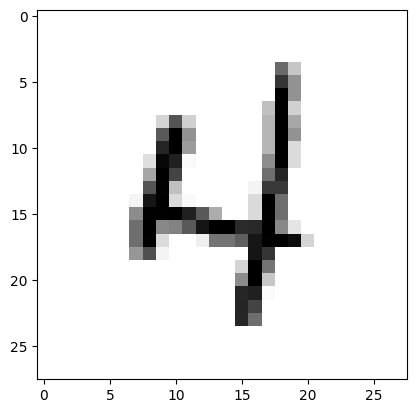

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

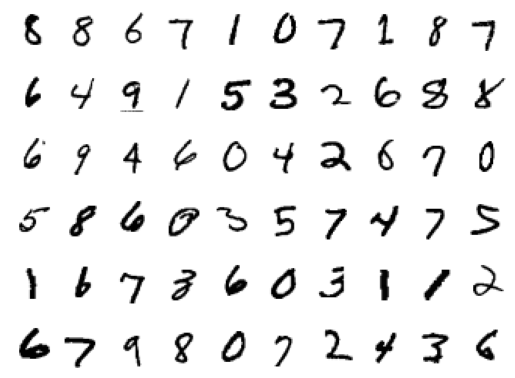

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [8]:
from src.models import models

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = models.NetWithRegularizer().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
model =  models.NetWithGAP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.35658156871795654 Batch_id=468 Accuracy=80.21: 100%|██████████| 469/469 [00:04<00:00, 107.73it/s]



Test set: Average loss: 0.4273, Accuracy: 9357/10000 (93.57%)

EPOCH: 1


Loss=0.1597203016281128 Batch_id=468 Accuracy=95.84: 100%|██████████| 469/469 [00:04<00:00, 110.85it/s] 



Test set: Average loss: 0.2412, Accuracy: 9545/10000 (95.45%)

EPOCH: 2


Loss=0.13811491429805756 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:04<00:00, 110.67it/s]



Test set: Average loss: 0.1648, Accuracy: 9670/10000 (96.70%)

EPOCH: 3


Loss=0.14206747710704803 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:04<00:00, 111.00it/s]



Test set: Average loss: 0.1328, Accuracy: 9734/10000 (97.34%)

EPOCH: 4


Loss=0.08365866541862488 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:04<00:00, 106.89it/s] 



Test set: Average loss: 0.1369, Accuracy: 9681/10000 (96.81%)

EPOCH: 5


Loss=0.07882727682590485 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:04<00:00, 109.60it/s] 



Test set: Average loss: 0.1225, Accuracy: 9697/10000 (96.97%)

EPOCH: 6


Loss=0.09393434971570969 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:04<00:00, 109.55it/s] 



Test set: Average loss: 0.0959, Accuracy: 9793/10000 (97.93%)

EPOCH: 7


Loss=0.056020308285951614 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:04<00:00, 108.62it/s]



Test set: Average loss: 0.1277, Accuracy: 9671/10000 (96.71%)

EPOCH: 8


Loss=0.06338932365179062 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:04<00:00, 108.20it/s] 



Test set: Average loss: 0.0824, Accuracy: 9818/10000 (98.18%)

EPOCH: 9


Loss=0.02620408870279789 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:04<00:00, 108.03it/s] 



Test set: Average loss: 0.0814, Accuracy: 9799/10000 (97.99%)

EPOCH: 10


Loss=0.16936229169368744 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:04<00:00, 107.02it/s] 



Test set: Average loss: 0.0745, Accuracy: 9815/10000 (98.15%)

EPOCH: 11


Loss=0.0764773041009903 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:04<00:00, 111.68it/s]  



Test set: Average loss: 0.0939, Accuracy: 9757/10000 (97.57%)

EPOCH: 12


Loss=0.11907241493463516 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:04<00:00, 105.33it/s] 



Test set: Average loss: 0.0833, Accuracy: 9800/10000 (98.00%)

EPOCH: 13


Loss=0.11982288956642151 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:04<00:00, 110.06it/s] 



Test set: Average loss: 0.0916, Accuracy: 9765/10000 (97.65%)

EPOCH: 14


Loss=0.05562309920787811 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:04<00:00, 109.46it/s] 



Test set: Average loss: 0.0857, Accuracy: 9786/10000 (97.86%)



Text(0.5, 1.0, 'Test Accuracy')

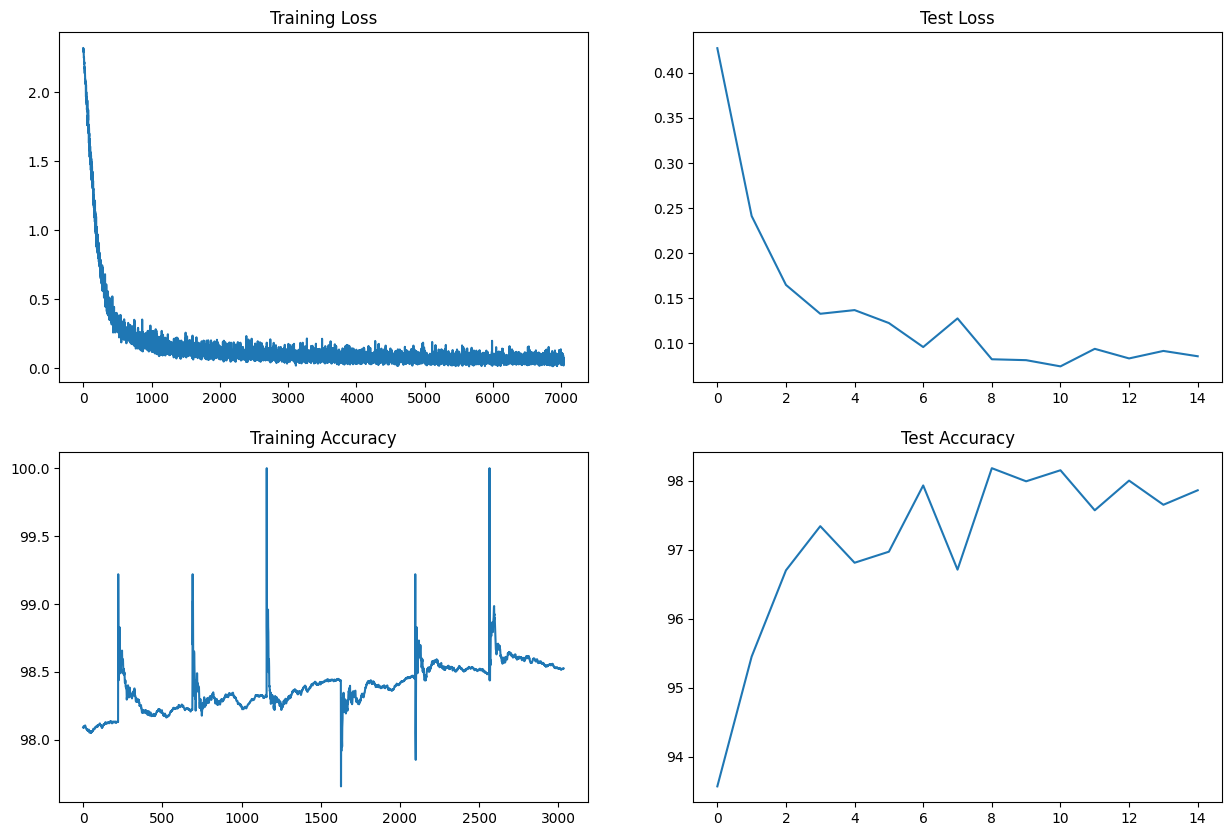

In [13]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target
- Increase model capacity at the end (add layer after GAP)
- Perform MaxPooling at RF=5
- Fix DropOut, add it to each layer

## Results
- **Parameters:** 13.8k
- **Best Train Accuracy:** 98.5
- **Best Test Accuracy:** 98.18 (8th Epoch)

## Analysis
- Works!
- But we're not seeing 99.4 or more as often as we'd like. We can further improve it.
- The model is not over-fitting at all.
- Seeing image samples, we can see that we can add slight rotation.

